In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split

In [2]:
X = pd.read_csv("../data/processed/X_reduced_rest.csv")
y = pd.read_csv("../data/processed/y_rest.csv").squeeze()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=10
)
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

X_train: (20875, 17)
X_test: (8947, 17)
y_train: (20875,)
y_test: (8947,)


In [4]:
# linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# test the model both train and test
train_score = lr_model.score(X_train, y_train)
test_score = lr_model.score(X_test, y_test)

print(f"Train Score: {train_score}")
print(f"Test Score: {test_score}")

Train Score: 0.9534163989489616
Test Score: 0.9538448451629948


In [5]:
# calculate intercept and coefficients
intercept = lr_model.intercept_
coefficients = lr_model.coef_
print("Intercept:", intercept)
print("Coefficients:", coefficients)

Intercept: 5935.981289344589
Coefficients: [ 7016.2393283  -1311.76470171  -708.19336921 14835.98820801
  6053.6241234     37.55826883   -55.25087215   -19.62254288
   -22.28967559  -700.32019985  3926.8127061   1979.45604663
   612.86623617   837.3951011   2800.66184334   -45.49136706
   243.07842087]


In [6]:
# feature importance based on coefficients
coef_df = pd.DataFrame(coefficients, index=X_test.columns, columns=["Coefficient"]).sort_values(by="Coefficient", ascending=True)


/tmp/ipykernel_209701/559273050.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")


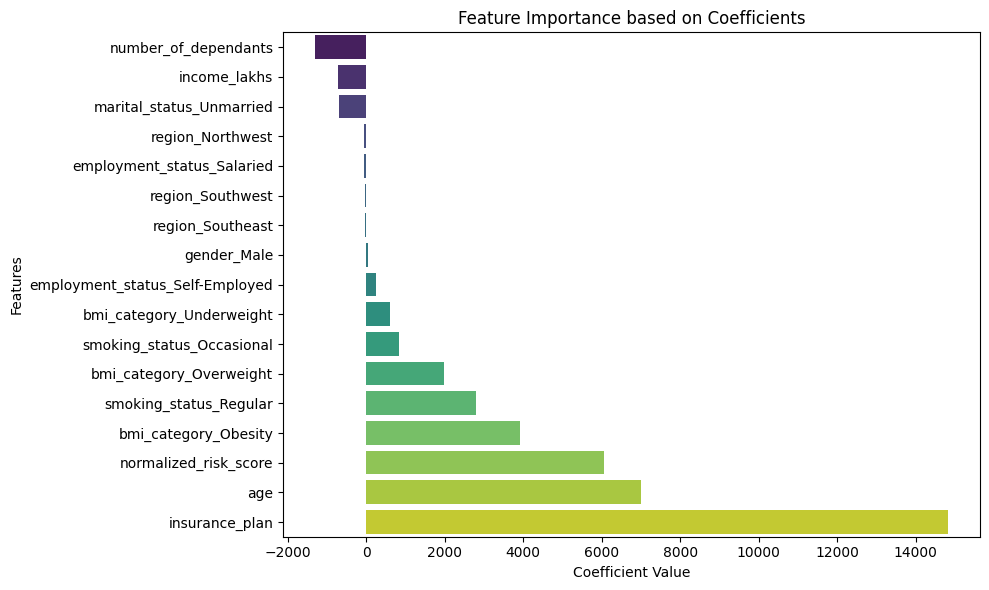

In [7]:
# create barh chart for coef_df
plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y=coef_df.index, data=coef_df, palette="viridis")
plt.title("Feature Importance based on Coefficients")
plt.xlabel("Coefficient Value")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [8]:
# use XGboost for better performance (optional)
from xgboost import XGBRegressor

# train XGBoost model
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# test the model both train and test
xgb_train_score = xgb_model.score(X_train, y_train)
xgb_test_score = xgb_model.score(X_test, y_test)

print(f"XGBoost Train Score: {xgb_train_score}")
print(f"XGBoost Test Score: {xgb_test_score}")

XGBoost Train Score: 0.9986370801925659
XGBoost Test Score: 0.9979538321495056


In [9]:
best_model = xgb_model

***Error Analysis**

In [10]:
y_pred = best_model.predict(X_test)

In [11]:
# residuals and pct.
residuals =  y_pred - y_test
residuals_pct = residuals  * 100 / y_test

results_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "diff": residuals,
    "diff_pct": residuals_pct
})

results_df.head()

,Actual,Predicted,diff,diff_pct
19656,26895,26611.138672,-283.861328,-1.055443
14704,22734,23093.667969,359.667969,1.582071
19874,21198,21507.083984,309.083984,1.458081
29562,9100,9087.669922,-12.330078,-0.135495
17027,26434,26533.542969,99.542969,0.376572


In [12]:
# find extreame errors threshold 10%
extreme_results_df = results_df[np.abs(results_df["diff_pct"]) > 10]
extreme_results_df.shape

(0, 4)

In [13]:
# pertange of error predictions
extreme_error_percentage = (extreme_results_df.shape[0] / results_df.shape[0]) * 100
extreme_error_percentage

0.0

In [14]:
X_test.index

Index([19656, 14704, 19874, 29562, 17027, 20255, 24821, 26647, 25772, 10696,
       ...
       10602,  1217, 16997, 19173,  9245,  3377,  7837,  9711,  4834,  8962],
      dtype='int64', length=8947)

In [15]:
extreme_results_df.index

Index([], dtype='int64')

In [16]:
extreme_error_df = X_test.loc[extreme_results_df.index]
extreme_error_df.head()

,age,number_of_dependants,income_lakhs,insurance_plan,normalized_risk_score,gender_Male,region_Northwest,region_Southeast,region_Southwest,marital_status_Unmarried,bmi_category_Obesity,bmi_category_Overweight,bmi_category_Underweight,smoking_status_Occasional,smoking_status_Regular,employment_status_Salaried,employment_status_Self-Employed


In [17]:
from joblib import dump
dump(best_model, '../artifacts/xgboost_rest_model.joblib')

['../artifacts/xgboost_rest_model.joblib']